# 0.Assignments

👾 這個陽春的聊天機器人需要被優化！<br>
若是一個對話串不間斷地持續進行，送進去的訊息量會很多，tokens數量也會跟著增加，會需要花比較多費用(💸💸💸)，也可能使模型的回應雜訊比較多而回應受到干擾，所以我們可以優化短期記憶。<br>
另外，我們希望優化使用者體驗，我們可以根據聊天的內容整理出使用者的屬性，並在每一次跟使用者聊天時，都能根據這個使用者的狀況給予客製化的回應，因此我們要加入長期記憶的功能！

<br>

### 1. 短期記憶優化

(1) 🔰 [基本版] 在短期記憶中，將chatbot node送入llm的訊息中加入trim的優化機制 (依據適當的tokens數量決定)


<br>

### 2. 加入長期記憶

加入長期記憶，讓聊天機器人能夠記住使用者的資訊（名字、偏好語言、興趣），在下一次對話也能針對同個使用者的資訊，給予個人化的回答。

(1) 🔰 [基本版]
- chatbot node: 在chatbot node中，將該使用者的資訊取出，讓入prompt中讓llm依據使用者的資訊給予個人化的回答

- write_memory node: 在每一次生成回答後，將使用者的資訊整理成一段對使用者的描述(使用llm，給予system prompt做指引，自行設計如何整理、需要整理哪些資訊)，將整理完的資訊整理到store (可跨threads存取的地方)。

- config: config從原本的短期記憶只有thread_id, 也要加入user_id

<img src="https://drive.google.com/uc?export=view&id=1H4Y0WplOi6R4Eo06Ac2JA_9TbZa2YaRD" width="100"/>


(2) 👨‍🎓 [進階版]
- chatbot node: 可以決定使用者的問題是否需要從長期記憶中取得資訊，以及需要取得什麼資訊
- write_memory node: 可以整理成特定格式 (例如：使用with_structured_output，相關概念可以延伸到R3 tool calling內容)。例如：
```
user_profile = {
  "first_name": "XXXX",
  "last_name": "OOO",
  "preferred_lang": ["en", "zh-tw"]
}
```
- 也可以自行將graph結構調整自己喜歡的(增刪不同node, conditional router, ...)
<br>
備註：基本版是需要大家完成的，進階版可以自行決定是否挑戰，Enjoy the ride! 😎

# 1.短期記憶

## (1) 基本版
🔰 [基本版] 在短期記憶中，將chatbot node送入llm的訊息中加入trim的優化機制 (依據適當的tokens數量決定)

note: 可以邊做邊看一下trim設定的效果以及內部運作的機制

In [1]:
%%capture --no-stderr
!pip install -U langgraph langchain_openai==0.3.15 langchain transformers bitsandbytes langchain-huggingface

In [ ]:
!pip install langchain_community

In [3]:
from google.colab import userdata
from langchain.chat_models import AzureChatOpenAI

# 從 secrets 中讀取值
api_key = userdata.get("OPENAI_KEY")
api_base = userdata.get("OPENAI_BASE")
deployment_name = userdata.get("OPENAI_DEPLOY")

# 初始化模型
llm_api = AzureChatOpenAI(
    openai_api_base=api_base,
    openai_api_version="2024-08-01-preview",  # 固定的版本
    deployment_name=deployment_name,
    openai_api_key=api_key,
    temperature=0.3,
)


<ipython-input-3-52002afac48f>:10: LangChainDeprecationWarning: The class `AzureChatOpenAI` was deprecated in LangChain 0.0.10 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-openai package and should be used instead. To use it run `pip install -U :class:`~langchain-openai` and import as `from :class:`~langchain_openai import AzureChatOpenAI``.
  llm_api = AzureChatOpenAI(
/usr/local/lib/python3.11/dist-packages/langchain_community/chat_models/azure_openai.py:174: UserWarning: As of openai>=1.0.0, Azure endpoints should be specified via the `azure_endpoint` param not `openai_api_base` (or alias `base_url`). Updating `openai_api_base` from https://intern-bryan.cognitiveservices.azure.com/ to https://intern-bryan.cognitiveservices.azure.com/openai.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/langchain_community/chat_models/azure_openai.py:181: UserWarning: As of openai>=1.0.0, if `deployment_name` (or alias `azure_deployment`) is 

In [4]:
import tiktoken
from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langchain_core.messages import convert_to_openai_messages, SystemMessage, HumanMessage, AIMessage, BaseMessage
from langchain_core.runnables.config import RunnableConfig

from langgraph.checkpoint.memory import MemorySaver


class State(TypedDict):
  """
  若只有messages, 其實等同於MessageState
  這邊保留彈性
  """
  messages: Annotated[list, add_messages]


encoding = tiktoken.encoding_for_model("gpt-4o-mini")

def get_token_length(text: str) -> int:
    return len(encoding.encode(text))

# MAX_TOKENS = 300

# 加入對話訊息修剪 (trim messages)
def trim_messages(messages: list, max_tokens: int) -> list:
    """
    修剪 messages，使總 token 數不超過 max_tokens。
    保留最新的訊息為主（從後往前加），直到達到限制。
    """
    trimmed = []
    total_tokens = 0

    for msg in reversed(messages):
        msg_tokens = get_token_length(msg.content)
        if total_tokens + msg_tokens > max_tokens:
            break
        trimmed.insert(0, msg)
        total_tokens += msg_tokens

    return trimmed


def chatbot(state: State, config: RunnableConfig):
    system_prompt = "你是個只能使用繁體中文回答的助理"
    mode = config["configurable"]["mode"]

    messages = state["messages"]
    trimmed_messages = trim_messages(messages, MAX_TOKENS)  # 修剪長度

    if mode == "local":
        converted = convert_to_openai_messages(trimmed_messages)
        system_message = [{"role": "system", "content": system_prompt}]
        prompt = tokenizer.apply_chat_template(
            system_message + converted,
            tokenize=False,
            add_generation_prompt=True
        )
        response = llm_local.invoke(prompt)
        return {"messages": [AIMessage(content=response)]}
    else:
        full_messages = [SystemMessage(content=system_prompt)] + trimmed_messages
        if mode == "openai_api":
            response = llm_api.invoke(full_messages)
        elif mode == "huggingface":
            response = llm_huggingface.invoke(full_messages)
        return {"messages": [response]}



# 建立一個有StateGraph
graph_builder = StateGraph(State)
#                     node name, 呼叫node時要觸發的邏輯(function or object)
graph_builder.add_node("chatbot", chatbot) # 在graph裡面加入chatbot的node
graph_builder.add_edge(START, "chatbot")
graph_builder.add_edge("chatbot", END)

# 加入記憶性
memory = MemorySaver()
graph = graph_builder.compile(checkpointer=memory)

In [5]:
def stream_graph_updates(user_input: str, config: dict):
    for event in graph.stream({"messages": [{"role": "user", "content": user_input}]}, config):
        if "chatbot" in event:
          for value in event.values():
            print("Assistant:", value["messages"][-1].content)

In [7]:
# 第一次對話 (thread_id: conversation_1)
mode = "openai_api"
config_1 = {"configurable": {"thread_id": "conversation_1", "mode": mode}} # thread_id: 對話id
MAX_TOKENS = 200

while True:
  try:
    user_input = input("User: ")
    if user_input.lower() in ["quit", "exit", "q"]:
      print("Goodbye!")
      break
    stream_graph_updates(user_input, config_1)
  except Exception as e:
    print(e)
    break

User: 安安你好呀！
Assistant: 安安！你好呀！有什麼我可以幫忙的嗎？
User: 來聊聊電影！
Assistant: 好的！你想聊哪部電影呢？或者有什麼特別的主題或角色想討論的嗎？
User: 我很喜歡看宮崎駿的電影唷！
Assistant: 宮崎駿的電影真的很棒！他的作品充滿了奇幻的元素和深刻的主題，像是環保、成長和人性等。你最喜歡哪一部電影呢？或者有沒有特別喜歡的角色？
User: 我最喜歡霍爾的移動城堡
Assistant: 《霍爾的移動城堡》是一部非常美麗的作品！故事中的魔法、愛情以及霍爾和蘇菲之間的關係都讓人感動。你喜歡這部電影的哪個部分呢？或者有什麼特別的感受嗎？
User: 我很喜歡霍爾的轉變，你知道嗎？霍爾一開始是美麗的金髮，但是遇見蘇菲之後，變回他最原本的髮色，也暗示了他遇見蘇菲之後變得更像自己！
Assistant: 你提到的這一點非常有趣！霍爾的轉變確實象徵著他內心的成長和回歸真實自我的過程。當他與蘇菲的關係逐漸加深時，他不再依賴外表的魅力，而是開始展現出真實的自我，這也讓他變得更加成熟和堅強。這樣的轉變不僅是外在的，也是內心的，讓整個故事更加深刻。你還有其他喜歡的角色或情節嗎？
User: 還有還有他的魔法四扇門，原本三個門都是不同的入口，而且都代表著霍爾以三個不同的名字的家，意味著他很害怕被壞人找到選擇躲藏，但遇見蘇菲之後，三扇門變成蘇菲最喜歡的地方，蘇菲的故鄉、漂亮的花園，還有跟蘇菲相遇的荒野，非常浪漫
Assistant: 這段描述非常美妙，展現了霍爾與蘇菲之間的深厚情感。霍爾的魔法四扇門不僅是他躲避壞人的工具，更是他心靈的象徵。當三扇門轉變為蘇菲喜愛的地方，這不僅代表著霍爾對蘇菲的愛與信任，也顯示出他願意打開心扉，讓蘇菲進入他的世界。這樣的轉變讓故事充滿了浪漫與希望，也讓人感受到愛情的力量如何改變一個人。這樣的情節設計讓整個故事更加動人，讓讀者對霍爾和蘇菲的關係充滿期待。
User: 最喜歡的肯定是他們相遇的時候，霍爾英雄救美，他們一起走在空中的畫面
Assistant: 那個場景確實非常感人，霍爾的英雄救美展現了他的勇氣和對愛情的堅持，而他們一起在空中漫步的畫面則充滿了浪漫與夢幻。這種奇幻的設定讓人感受到愛情的力量，也讓整個故事更加動人。你最喜歡這部作品的哪個部分呢？
User: 我們先來聊聊別的吧！
Assista

In [8]:
# 易讀版
def state_pretty_print(state: State):
  for m in state.values["messages"]:
    m.pretty_print()

In [9]:
state_pretty_print(graph.get_state(config_1))

================================ Human Message =================================

安安你好呀！
================================== Ai Message ==================================

安安！你好呀！有什麼我可以幫你解答的嗎？
================================ Human Message =================================

我很喜歡看宮崎駿的電影唷！
================================== Ai Message ==================================

宮崎駿的電影真的很棒！他的作品充滿了奇幻的世界和深刻的情感，像《天空之城》、《龍貓》和《千與千尋》等都是經典之作。你最喜歡哪一部呢？
================================ Human Message =================================

我最喜歡霍爾的移動城堡
================================== Ai Message ==================================

《霍爾的移動城堡》是一部非常美麗的電影！故事中的魔法和愛情，以及霍爾和蘇菲之間的關係都讓人感動。你最喜歡電影中的哪個角色或場景呢？
================================ Human Message =================================

我很喜歡霍爾的轉變，你知道嗎？霍爾一開始是美麗的金髮，但是遇見蘇菲之後，變回他最原本的髮色，也暗示了他遇見蘇菲之後變得更像自己！
================================== Ai Message ==================================

你說得很對！霍爾的轉變確實非常有意義，象徵著他在愛情中的成長和自我認識。蘇菲的出現讓他重新找回了真實的自己，這種轉變也反映了愛情的力量。電影中的這些細節真的很深刻，讓人感受到角色之間的

---

# 2.長期記憶

## (1) 基本版
🔰 [基本版]
- chatbot node: 在chatbot node中，將該使用者的資訊取出，讓入prompt中讓llm依據使用者的資訊給予個人化的回答

- write_memory node: 在每一次生成回答後，將使用者的資訊整理成一段對使用者的描述(使用llm，給予system prompt做指引，自行設計如何整理、需要整理哪些資訊)，將整理完的資訊整理到store (可跨threads存取的地方)。

- config: config從原本的短期記憶只有thread_id, 也要加入user_id

<img src="https://drive.google.com/uc?export=view&id=1H4Y0WplOi6R4Eo06Ac2JA_9TbZa2YaRD" width="100"/>

In [7]:
%%capture --no-stderr
!pip install -U langgraph langchain_openai==0.3.15 langchain transformers bitsandbytes langchain-huggingface

In [10]:
%%capture --no-stderr
!pip install langchain_core

In [11]:
from typing import Annotated
from typing_extensions import TypedDict
from langgraph.checkpoint.memory import MemorySaver # within-thread memory
from langgraph.store.memory import InMemoryStore # cross-thread store

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages

from langchain_core.messages import HumanMessage, SystemMessage, AIMessage

In [88]:
import json
import re

# 初始化長期記憶儲存區
store = InMemoryStore()

# 初始化短期記憶（每個 thread 的 message history）
memory = MemorySaver()


class State(TypedDict):
  """
  若只有messages, 其實等同於MessageState
  這邊保留彈性
  """
  messages: Annotated[list, add_messages]


# 依據user_id取得長期記憶
# 將長期記憶也放進system prompt中，讓llm可以個人化回覆
def chatbot(state: State, config):
    user_id = config["configurable"]["user_id"]
    mode = config["configurable"]["mode"]

    # 搜尋並解析長期記憶
    memories_raw = store.search((user_id, "memories"))

    if isinstance(memories_raw, dict):
        user_memories = memories_raw
    elif isinstance(memories_raw, list):
        try:
            # 嘗試將 list of tuple 轉成 dict
            user_memories = dict(memories_raw)
        except Exception:
            user_memories = {}
    else:
        user_memories = {}

    user_info = user_memories.get("profile", {})

    # 建立個人化 system prompt
    base_prompt = "你是個只能使用繁體中文回答的助理，請根據以下使用者資訊提供個人化的回答，並自然地反映你對她的了解（例如名字、喜好）"
    user_desc = f"使用者資訊：{user_info}" if user_info else "目前沒有使用者資訊。"
    system_prompt = f"{base_prompt}\n{user_desc}"

    messages = state["messages"]

    if mode == "openai_api":
        response = llm_api.invoke([SystemMessage(content=system_prompt)] + messages)
    elif mode == "huggingface":
        response = llm_huggingface.invoke([SystemMessage(content=system_prompt)] + messages)
    else:
        raise ValueError("Unknown mode")

    return {"messages": [response]}


 # 將使用者的對話整理成要儲存成長期記憶的資訊，並存入長期記憶
def write_memory(state: State, config):
    user_id = config["configurable"]["user_id"]
    messages = state["messages"]

    # 請求 LLM 輸出使用者描述
    summary_prompt = SystemMessage(content="""
    請根據以下對話內容，以合法的 JSON 格式更新使用者資訊。請勿加上 ```json 或任何語法標記。格式範例如下：
    {
      "name": "ㄈㄈ",
      "style": "會聊動畫到哇酷哇酷的女子，希望你可以跟她一起哇酷哇酷",
    }
    """)
    summary_response = llm_api.invoke([summary_prompt] + messages)
    raw_content = summary_response.content.strip()

    # 移除可能的 markdown 包裝 ```json
    cleaned = re.sub(r"```json|```", "", raw_content).strip()

    try:
        parsed_value = json.loads(cleaned)
        store.put(namespace=(user_id, "memories"), key="profile", value=parsed_value)
    except json.JSONDecodeError as e:
        print("記憶儲存錯誤：", e)
        print("回傳內容：", summary_response.content)

    return {"messages": messages}


In [89]:
# Define the graph
builder = StateGraph(State)
builder.add_node("chatbot", chatbot)
builder.add_node("write_memory", write_memory)
builder.add_edge(START, "chatbot")
builder.add_edge("chatbot", "write_memory")
builder.add_edge("write_memory", END)

# Compile the graph with the checkpointer fir and store
graph = builder.compile(checkpointer=memory, store=store) # 加入短期與長期記憶

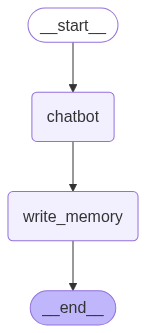

In [90]:
# View
from IPython.display import Image, display
try:
  display(Image(graph.get_graph().draw_mermaid_png()))
except Exception as e:
  print(e)
  pass

In [91]:
def stream_graph_updates(user_input: str, config: dict):
    for event in graph.stream({"messages": [{"role": "user", "content": user_input}]}, config):
        if "chatbot" in event:
          for value in event.values():
              print("Assistant:", value["messages"][-1].content)

In [92]:
# 使用者A的第一次對話
config = {
    "configurable": {
        "thread_id": "thread_001",
        "user_id": "user_1",
        "mode": "openai_api"
    }
}

In [93]:
store.put(
    namespace=("user_1", "memories"),
    key="profile",
    value={
        "name": "ㄈㄈ",
        "style": "會聊動畫到哇酷哇酷的女子，希望你可以跟她一起哇酷哇酷",
        "favorite_movies": ["霍爾的移動城堡", "神隱少女"],
        "favorite_charactors": ["霍爾", "白龍"]
    }
)

In [94]:
print("使用者記憶內容：")
print(store.search(("user_1", "memories")))

使用者記憶內容：
[Item(namespace=['user_1', 'memories'], key='profile', value={'name': 'ㄈㄈ', 'style': '會聊動畫到哇酷哇酷的女子，希望你可以跟她一起哇酷哇酷', 'favorite_movies': ['霍爾的移動城堡', '神隱少女'], 'favorite_charactors': ['霍爾', '白龍']}, created_at='2025-06-03T15:59:43.957873+00:00', updated_at='2025-06-03T15:59:43.957877+00:00', score=None)]


In [95]:
# 開始對話 (可以輸入quit, exit, q，三選一停止對話)
while True:
  try:
    user_input = input("User: ")
    if user_input.lower() in ["quit", "exit", "q"]:
      print("Goodbye!")
      break
    stream_graph_updates(user_input, config)
  except Exception as e:
    print("錯誤：", e)
    break

User: 你覺得我的聊天風格如何呢？
Assistant: 雖然我還不太了解你的聊天風格，但我很期待能夠多了解你！如果你願意分享一些你的喜好或風格，我會更能針對性地回應你喔。你喜歡輕鬆的對話，還是更喜歡深入的討論呢？
User: 你對我沒有任何記憶嗎？
Assistant: 是的，我沒有記憶，無法保存之前的對話內容。不過，我隨時都可以根據你當前的問題或話題來提供幫助！如果你有任何想分享的資訊或問題，隨時告訴我，我會盡力協助你。
User: 我好難過，我已經賦予你記憶性了，12點了，我該睡了，晚安
Assistant: 我很抱歉讓你感到難過，雖然我無法記住過去的對話，但我會一直在這裡支持你。希望你能好好休息，明天會是更美好的一天。晚安，祝你好夢！
User: exit
Goodbye!
